<a href="https://colab.research.google.com/github/yonathanarbel/AI-LAW/blob/main/Class_4_Decision_Trees_for_Lawyers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

from IPython.display import display, HTML, Markdown
from ipywidgets import interact, widgets, VBox, HBox, Output
from graphviz import Digraph
import matplotlib.pyplot as plt



# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 2000

# Generate random data for features (continuous variables between 0 and 10)
data = pd.DataFrame({
    'Control': np.random.uniform(0, 10, size=n_samples),
    'Tools': np.random.uniform(0, 10, size=n_samples),
    'Integration': np.random.uniform(0, 10, size=n_samples)
})

# Define a more complex relationship between factors
def complex_score(control, tools, integration):
    base_score = (
        0.4 * control +
        0.3 * tools +
        0.3 * integration
    )

    # Add non-linear interactions
    interaction_score = (
        0.1 * control * integration +
        -0.05 * tools * control +
        0.15 * np.sin(integration)
    )

    # Add some threshold effects
    threshold_score = (
        0.2 * (control > 7) +
        0.15 * (tools < 3) +
        0.25 * (integration > 8)
    )

    return base_score + interaction_score + threshold_score

# Calculate the score for each sample
data['Score'] = data.apply(lambda row: complex_score(row['Control'], row['Tools'], row['Integration']), axis=1)

# Apply classification rule
data['Classification'] = np.where(data['Score'] >= 5, 'Employee', 'Independent Contractor')



In [ ]:
# Generate 10 examples
names = ["Nathan", "Emma", "Liam", "Olivia", "Noah", "Ava", "Ethan", "Sophia", "Mason", "Isabella"]

examples = []
for i in range(10):
    row = data.iloc[i]
    example = f"{names[i]} is a worker whose employer/hiring party has a {row['Control']*10:.1f}% control over their work. "
    example += f"In assessing how much the tools used in the work were provided by the hiring party, it was ranked {row['Tools']*10:.1f}%. "
    example += f"The integration of the work into the hiring party's business was assessed at {row['Integration']*10:.1f}%. "
    example += f"Based on these factors and their complex interactions, a court decided that {names[i]} "
    example += f"{'is' if row['Classification'] == 'Employee' else 'is not'} an employee."
    examples.append(example)

# Create a styled HTML table for the examples
html_table = "<table style='width:100%; border-collapse: collapse;'>"
html_table += "<tr style='background-color: #f2f2f2;'><th style='padding: 10px; border: 1px solid #ddd;'>Example</th></tr>"
for i, example in enumerate(examples, 1):
    html_table += f"<tr><td style='padding: 10px; border: 1px solid #ddd;'><b>Example {i}:</b> {example}</td></tr>"
html_table += "</table>"

# Display the examples in a nicely formatted table
display(HTML(html_table))

In [ ]:
np.random.seed(42)

n_samples = 1000

data = pd.DataFrame({
    'Control': np.random.uniform(0, 10, size=n_samples),
    'Tools': np.random.uniform(0, 10, size=n_samples),
    'Integration': np.random.uniform(0, 10, size=n_samples)
})

def complex_score(control, tools, integration):
    base_score = (
        0.4 * control +
        0.3 * tools +
        0.3 * integration
    )

    interaction_score = (
        0.1 * control * integration +
        -0.05 * tools * control +
        0.15 * np.sin(integration)
    )

    threshold_score = (
        0.2 * (control > 7) +
        0.15 * (tools < 3) +
        0.25 * (integration > 8)
    )

    return base_score + interaction_score + threshold_score

data['Score'] = data.apply(lambda row: complex_score(row['Control'], row['Tools'], row['Integration']), axis=1)

data['Classification'] = np.where(data['Score'] >= 5, 'Employee', 'Independent Contractor')

data = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_data = data.iloc[:800]
val_data = data.iloc[800:]

X_train = train_data[['Control', 'Tools', 'Integration']]
y_train = train_data['Classification']

X_val = val_data[['Control', 'Tools', 'Integration']]
y_val = val_data['Classification']

def calculate_split(feature, threshold):
    left_split = X_train[feature] <= threshold
    right_split = X_train[feature] > threshold

    total_employees = y_train[y_train == 'Employee'].shape[0]
    total_independent = y_train[y_train == 'Independent Contractor'].shape[0]

    n_employees_left = y_train[left_split].value_counts().get('Employee', 0)
    n_employees_right = y_train[right_split].value_counts().get('Employee', 0)

    n_independent_left = y_train[left_split].value_counts().get('Independent Contractor', 0)
    n_independent_right = y_train[right_split].value_counts().get('Independent Contractor', 0)

    percent_employees_left = (n_employees_left / total_employees) * 100
    percent_employees_right = (n_employees_right / total_employees) * 100

    percent_independent_left = (n_independent_left / total_independent) * 100
    percent_independent_right = (n_independent_right / total_independent) * 100

    return percent_employees_left, percent_employees_right, percent_independent_left, percent_independent_right

def display_splits(output, feature, threshold):
    with output:
        output.clear_output(wait=True)
        percent_employees_left, percent_employees_right, percent_independent_left, percent_independent_right = calculate_split(feature, threshold)
        display(Markdown(f"**{percent_employees_left:.2f}% of Employees go to the left node**"))
        display(Markdown(f"**{percent_employees_right:.2f}% of Employees go to the right node**"))
        display(Markdown(f"**{percent_independent_left:.2f}% of Independent Contractors go to the left node**"))
        display(Markdown(f"**{percent_independent_right:.2f}% of Independent Contractors go to the right node**"))

def decision_tree_predict(X, node0_feature, node0_threshold,
                          node1_feature, node1_threshold,
                          node2_feature, node2_threshold,
                          node3_feature, node3_threshold,
                          node4_feature, node4_threshold,
                          node5_feature, node5_threshold,
                          node6_feature, node6_threshold):
    predictions = []
    for _, row in X.iterrows():
        if row[node0_feature] <= node0_threshold:
            if row[node1_feature] <= node1_threshold:
                if row[node3_feature] <= node3_threshold:
                    predictions.append('Employee')
                else:
                    predictions.append('Independent Contractor')
            else:
                if row[node4_feature] <= node4_threshold:
                    predictions.append('Employee')
                else:
                    predictions.append('Independent Contractor')
        else:
            if row[node2_feature] <= node2_threshold:
                if row[node5_feature] <= node5_threshold:
                    predictions.append('Employee')
                else:
                    predictions.append('Independent Contractor')
            else:
                if row[node6_feature] <= node6_threshold:
                    predictions.append('Employee')
                else:
                    predictions.append('Independent Contractor')
    return predictions

def interactive_decision_tree(
    node0_feature, node0_threshold,
    node1_feature, node1_threshold,
    node2_feature, node2_threshold,
    node3_feature, node3_threshold,
    node4_feature, node4_threshold,
    node5_feature, node5_threshold,
    node6_feature, node6_threshold):

    train_predictions = decision_tree_predict(
        X_train,
        node0_feature, node0_threshold,
        node1_feature, node1_threshold,
        node2_feature, node2_threshold,
        node3_feature, node3_threshold,
        node4_feature, node4_threshold,
        node5_feature, node5_threshold,
        node6_feature, node6_threshold
    )

    val_predictions = decision_tree_predict(
        X_val,
        node0_feature, node0_threshold,
        node1_feature, node1_threshold,
        node2_feature, node2_threshold,
        node3_feature, node3_threshold,
        node4_feature, node4_threshold,
        node5_feature, node5_threshold,
        node6_feature, node6_threshold
    )

    train_accuracy = accuracy_score(y_train, train_predictions)
    val_accuracy = accuracy_score(y_val, val_predictions)

    print(f'Training Accuracy: {train_accuracy*100:.2f}%')
    print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

    print('\nTraining Confusion Matrix:')
    cm_train = confusion_matrix(y_train, train_predictions, labels=['Employee', 'Independent Contractor'])
    cm_train_df = pd.DataFrame(cm_train, index=['Actual Employee', 'Actual Independent Contractor'], columns=['Predicted Employee', 'Predicted Independent Contractor'])
    display(cm_train_df)

    print('\nValidation Confusion Matrix:')
    cm_val = confusion_matrix(y_val, val_predictions, labels=['Employee', 'Independent Contractor'])
    cm_val_df = pd.DataFrame(cm_val, index=['Actual Employee', 'Actual Independent Contractor'], columns=['Predicted Employee', 'Predicted Independent Contractor'])
    display(cm_val_df)

def visualize_tree(node0_feature, node0_threshold,
                   node1_feature, node1_threshold,
                   node2_feature, node2_threshold,
                   node3_feature, node3_threshold,
                   node4_feature, node4_threshold,
                   node5_feature, node5_threshold,
                   node6_feature, node6_threshold):

    dot = Digraph()
    dot.node('0', f'{node0_feature} ≤ {node0_threshold:.2f}')

    dot.node('1', f'{node1_feature} ≤ {node1_threshold:.2f}')
    dot.edge('0', '1', label='True')

    dot.node('2', f'{node2_feature} ≤ {node2_threshold:.2f}')
    dot.edge('0', '2', label='False')

    dot.node('3', f'{node3_feature} ≤ {node3_threshold:.2f}')
    dot.edge('1', '3', label='True')

    dot.node('4', f'{node4_feature} ≤ {node4_threshold:.2f}')
    dot.edge('1', '4', label='False')

    dot.node('5', f'{node5_feature} ≤ {node5_threshold:.2f}')
    dot.edge('2', '5', label='True')

    dot.node('6', f'{node6_feature} ≤ {node6_threshold:.2f}')
    dot.edge('2', '6', label='False')

    dot.node('7', 'Predict Employee')
    dot.edge('3', '7', label='True')

    dot.node('8', 'Predict Independent Contractor')
    dot.edge('3', '8', label='False')

    dot.node('9', 'Predict Employee')
    dot.edge('4', '9', label='True')

    dot.node('10', 'Predict Independent Contractor')
    dot.edge('4', '10', label='False')

    dot.node('11', 'Predict Employee')
    dot.edge('5', '11', label='True')

    dot.node('12', 'Predict Independent Contractor')
    dot.edge('5', '12', label='False')

    dot.node('13', 'Predict Employee')
    dot.edge('6', '13', label='True')

    dot.node('14', 'Predict Independent Contractor')
    dot.edge('6', '14', label='False')

    return dot

node_feature_widgets = []
node_threshold_widgets = []
split_outputs = []

for i in range(7):
    node_feature_widget = widgets.Dropdown(
        options=['Control', 'Tools', 'Integration'],
        value=random.choice(['Control', 'Tools', 'Integration']),
        description=f'Node {i} Feature:'
    )
    node_threshold_widget = widgets.FloatSlider(
        min=0,
        max=10,
        step=0.1,
        value=round(random.uniform(0, 10), 2),
        description=f'Node {i} Threshold:'
    )
    split_output = widgets.Output()

    node_feature_widgets.append(node_feature_widget)
    node_threshold_widgets.append(node_threshold_widget)
    split_outputs.append(split_output)

nodes_layout = []
for i in range(7):
    node_box = widgets.VBox([node_feature_widgets[i], node_threshold_widgets[i], split_outputs[i]])
    nodes_layout.append(node_box)

result_output = widgets.Output()
viz_output = widgets.Output()

def update_visualization():
    with viz_output:
        clear_output(wait=True)
        dot = visualize_tree(
            node_feature_widgets[0].value, node_threshold_widgets[0].value,
            node_feature_widgets[1].value, node_threshold_widgets[1].value,
            node_feature_widgets[2].value, node_threshold_widgets[2].value,
            node_feature_widgets[3].value, node_threshold_widgets[3].value,
            node_feature_widgets[4].value, node_threshold_widgets[4].value,
            node_feature_widgets[5].value, node_threshold_widgets[5].value,
            node_feature_widgets[6].value, node_threshold_widgets[6].value
        )
        display(dot)

def update_results_and_viz(*args):
    with result_output:
        clear_output(wait=True)
        interactive_decision_tree(
            node_feature_widgets[0].value, node_threshold_widgets[0].value,
            node_feature_widgets[1].value, node_threshold_widgets[1].value,
            node_feature_widgets[2].value, node_threshold_widgets[2].value,
            node_feature_widgets[3].value, node_threshold_widgets[3].value,
            node_feature_widgets[4].value, node_threshold_widgets[4].value,
            node_feature_widgets[5].value, node_threshold_widgets[5].value,
            node_feature_widgets[6].value, node_threshold_widgets[6].value
        )

    update_visualization()

    for i in range(7):
        display_splits(split_outputs[i], node_feature_widgets[i].value, node_threshold_widgets[i].value)

for i in range(7):
    node_feature_widgets[i].observe(update_results_and_viz, names='value')
    node_threshold_widgets[i].observe(update_results_and_viz, names='value')

main_layout = widgets.VBox([
    widgets.HBox(nodes_layout[:4]),
    widgets.HBox(nodes_layout[4:]),
    result_output,
    viz_output
])

display(main_layout)

update_results_and_viz()

In [ ]:
# Use the same data as the students (first 800 samples for training, last 200 for validation)
X_train = data[['Control', 'Tools', 'Integration']].iloc[:800]
y_train = data['Classification'].iloc[:800]
X_val = data[['Control', 'Tools', 'Integration']].iloc[800:1000]
y_val = data['Classification'].iloc[800:1000]

# Create and train the decision tree model
dt_model = DecisionTreeClassifier(
    max_depth=3,
    #min_samples_split=20,
    #min_samples_leaf=10,
    random_state=42
)
dt_model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_train_pred = dt_model.predict(X_train)
y_val_pred = dt_model.predict(X_val)
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Custom function to create node labels
def custom_node_text(decision_tree, feature_names):
    left = decision_tree.tree_.children_left
    right = decision_tree.tree_.children_right
    threshold = decision_tree.tree_.threshold
    features = [feature_names[i] for i in decision_tree.tree_.feature]
    value = decision_tree.tree_.value

    def recurse(node, depth):
        if left[node] == right[node]:
            samples = value[node][0].sum()
            employee_percent = (value[node][0][1] / samples) * 100
            return f"Samples = {samples}\n% Employee = {employee_percent:.1f}"
        else:
            feature = features[node]
            threshold_value = threshold[node]
            samples = value[node][0].sum()
            return f"{feature} <= {threshold_value:.2f}\nSamples = {samples}"

    return recurse

# Visualize the decision tree with custom labels
plt.figure(figsize=(20,10))
plot_tree(dt_model,
          feature_names=['Control', 'Tools', 'Integration'],
          class_names=['Independent Contractor', 'Employee'],
          filled=True,
          rounded=True,
          fontsize=10)

# Modify the text in each node
for i, (text, ax) in enumerate(zip(plt.gcf().texts, plt.gcf().axes)):
    custom_text = custom_node_text(dt_model, ['Control', 'Tools', 'Integration'])(i, 0)
    ax.clear()
    ax.text(0.5, 0.5, custom_text, ha='center', va='center', wrap=True)

plt.title("Optimal Decision Tree for Employee Classification")
plt.tight_layout()
plt.show()

# Display feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance)

# Print out the decision rules
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != -2:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else:  # if {name} > {threshold:.2f}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            class_counts = tree_.value[node][0]
            total = sum(class_counts)
            employee_percentage = (class_counts[1] / total) * 100
            majority_class = 'Employee' if employee_percentage > 50 else 'Independent Contractor'
            print(f"{indent}return {majority_class}  # In this node, % Employee = {employee_percentage:.1f}")

    print("def predict_employee_status(Control, Tools, Integration):")
    recurse(0, 1)

print("\nDecision Rules:")
tree_to_code(dt_model, ['Control', 'Tools', 'Integration'])

# Code for students to visualize their decision tree
def visualize_student_tree(node0_feature, node0_threshold,
                           node1_feature, node1_threshold,
                           node2_feature, node2_threshold,
                           node3_feature, node3_threshold,
                           node4_feature, node4_threshold,
                           node5_feature, node5_threshold,
                           node6_feature, node6_threshold):

    def decision_tree_predict(X, node0_feature, node0_threshold,
                              node1_feature, node1_threshold,
                              node2_feature, node2_threshold,
                              node3_feature, node3_threshold,
                              node4_feature, node4_threshold,
                              node5_feature, node5_threshold,
                              node6_feature, node6_threshold):
        predictions = []
        for _, row in X.iterrows():
            if row[node0_feature] <= node0_threshold:
                if row[node1_feature] <= node1_threshold:
                    if row[node3_feature] <= node3_threshold:
                        predictions.append('Employee')
                    else:
                        predictions.append('Independent Contractor')
                else:
                    if row[node4_feature] <= node4_threshold:
                        predictions.append('Employee')
                    else:
                        predictions.append('Independent Contractor')
            else:
                if row[node2_feature] <= node2_threshold:
                    if row[node5_feature] <= node5_threshold:
                        predictions.append('Employee')
                    else:
                        predictions.append('Independent Contractor')
                else:
                    if row[node6_feature] <= node6_threshold:
                        predictions.append('Employee')
                    else:
                        predictions.append('Independent Contractor')
        return predictions

    # Make predictions
    train_predictions = decision_tree_predict(X_train, node0_feature, node0_threshold,
                                              node1_feature, node1_threshold,
                                              node2_feature, node2_threshold,
                                              node3_feature, node3_threshold,
                                              node4_feature, node4_threshold,
                                              node5_feature, node5_threshold,
                                              node6_feature, node6_threshold)

    val_predictions = decision_tree_predict(X_val, node0_feature, node0_threshold,
                                            node1_feature, node1_threshold,
                                            node2_feature, node2_threshold,
                                            node3_feature, node3_threshold,
                                            node4_feature, node4_threshold,
                                            node5_feature, node5_threshold,
                                            node6_feature, node6_threshold)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, train_predictions)
    val_accuracy = accuracy_score(y_val, val_predictions)

    print(f"Training Accuracy: {train_accuracy:.2f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}")

    # Create a visual representation of the decision tree
    dot = Digraph()
    dot.node('0', f'{node0_feature} ≤ {node0_threshold:.2f}')

    dot.node('1', f'{node1_feature} ≤ {node1_threshold:.2f}')
    dot.edge('0', '1', label='True')

    dot.node('2', f'{node2_feature} ≤ {node2_threshold:.2f}')
    dot.edge('0', '2', label='False')

    dot.node('3', f'{node3_feature} ≤ {node3_threshold:.2f}')
    dot.edge('1', '3', label='True')

    dot.node('4', f'{node4_feature} ≤ {node4_threshold:.2f}')
    dot.edge('1', '4', label='False')

    dot.node('5', f'{node5_feature} ≤ {node5_threshold:.2f}')
    dot.edge('2', '5', label='True')

    dot.node('6', f'{node6_feature} ≤ {node6_threshold:.2f}')
    dot.edge('2', '6', label='False')

    # Add leaf nodes
    leaf_nodes = ['7', '8', '9', '10', '11', '12', '13', '14']
    parent_nodes = ['3', '3', '4', '4', '5', '5', '6', '6']
    edges = ['True', 'False', 'True', 'False', 'True', 'False', 'True', 'False']

    for leaf, parent, edge in zip(leaf_nodes, parent_nodes, edges):
        dot.node(leaf, 'Leaf')
        dot.edge(parent, leaf, label=edge)

    return dot



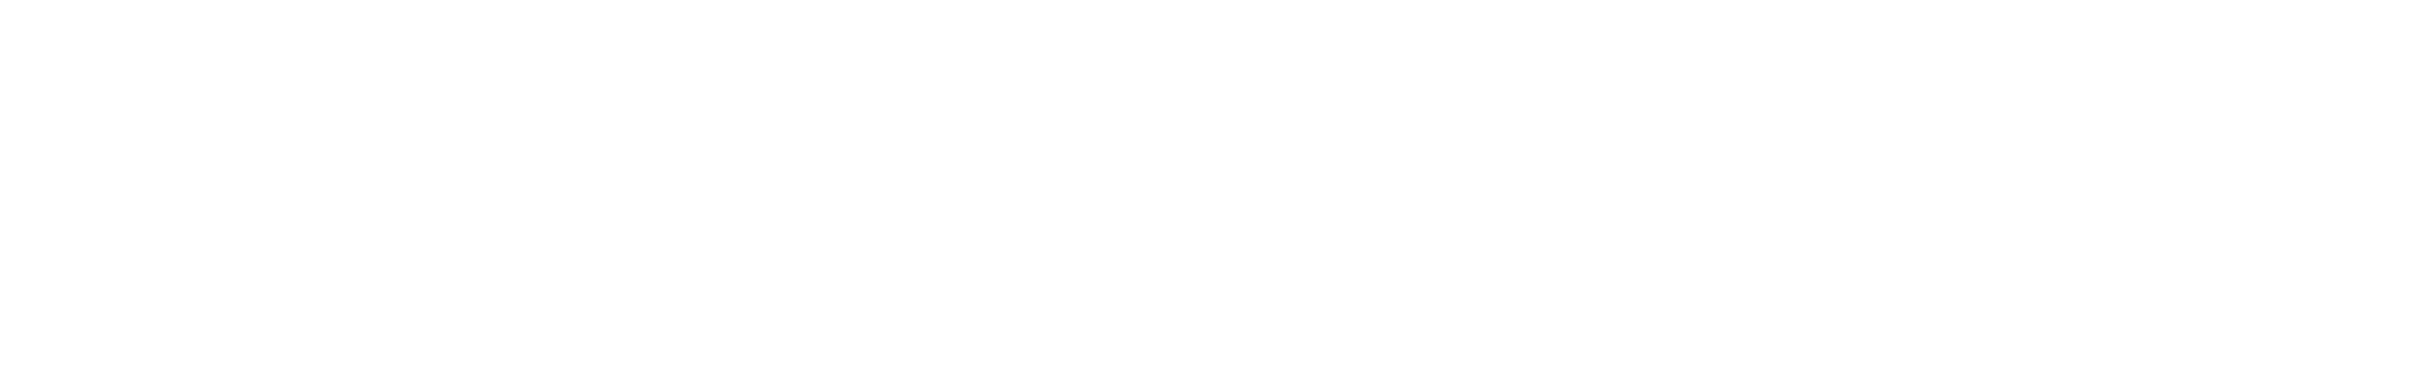